## Objectives
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Import important packages

In [121]:
import pandas as pd
#Pandas is used for data manipulation and analysis.
from sklearn.preprocessing import StandardScaler
# Scaling is used in all unsupervised models
import numpy as np
# NumPy is a library for numerical computing in Python.
import matplotlib.pyplot as plt
import seaborn as sns
# Seaborn is a library for creating informative and attractive statistical graphics in Python.
from sklearn.cluster import KMeans
# KMeans is an algorithm for clustering data points into a pre-specified number of clusters based on their similarities.
from sklearn.cluster import DBSCAN
# DBSCAN groups together points that are close to each other in a high-density region
# while marking out noise points in low-density regions

## Load and explore the data

In [122]:
path = "Credit+Card+Customer+Data.xlsx"
data = pd.read_excel(path)
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


The data consists of the following columns
- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [123]:
data.shape

(660, 7)

- there are 660 rows and 7 columns in the data

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [125]:
data.duplicated().sum()

0

- no duplicates in the data

In [126]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


- the descriptive statistics doesn't look problematic

SI_No and Customer Key should be removed since they are not adding any information to the data. We can identify the correlation between the features to confirm this

In [127]:
mat_corr = data.corr()
mat_corr

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,1.000000,0.052886,0.677962,0.739329,0.406438,0.033916,-0.684125
Customer Key,0.052886,1.000000,0.068604,-0.010281,-0.000560,0.022506,0.005968
Avg_Credit_Limit,0.677962,0.068604,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.739329,-0.010281,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,0.406438,-0.000560,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.033916,0.022506,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.684125,0.005968,-0.414352,-0.651251,-0.506016,0.127299,1.000000


<AxesSubplot:>

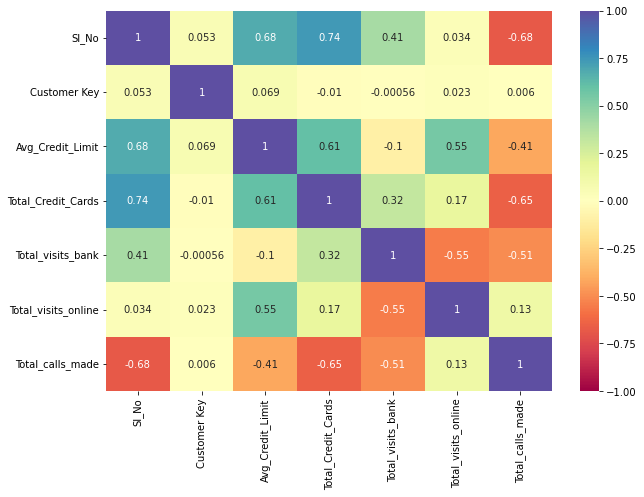

In [128]:
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(mat_corr, annot= True, vmin = -1, vmax = 1, cmap ="Spectral")

- customer key is the only feature with no relevant information on the data. the column should be removed

## Data visualization

### Univariate analysis

In [129]:
list(data)

['Sl_No',
 'Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

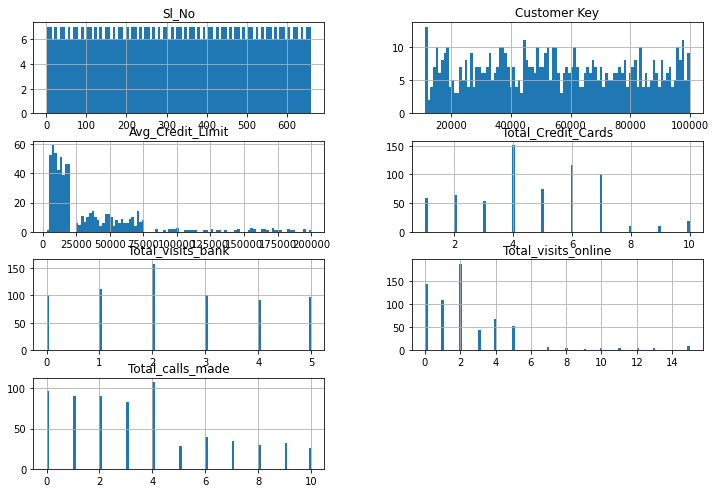

In [130]:
columns = list(data)
data[columns].hist(stacked = False, bins = 100, figsize = (12,30),
                 layout = (14,2) )
plt.tight_layout# to prevent title from overlapping;

- average credit limit and total visits online are right skewed
- other columns are normally distributed

### Multivariate analysis

In [131]:
list(data)

['Sl_No',
 'Customer Key',
 'Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<function matplotlib.pyplot.show(close=None, block=None)>

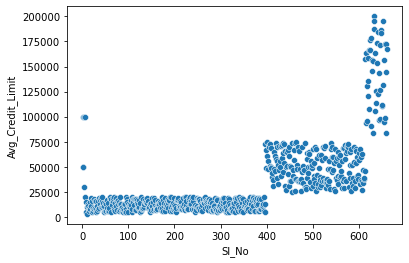

In [132]:
# Relationship between SI_No and Average credit limit
sns.scatterplot( data = data, x = "Sl_No" , y ="Avg_Credit_Limit" )
plt.show

- Average credit limit increases with increase in SI number

<function matplotlib.pyplot.show(close=None, block=None)>

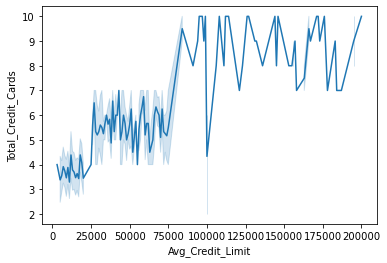

In [133]:
# relationship between Avg_Credit_Limit and total credit card
sns.lineplot( data = data, x = "Avg_Credit_Limit" , y ="Total_Credit_Cards" )
plt.show

- total credit card somewhat increases with an increase in average credit limit

<function matplotlib.pyplot.show(close=None, block=None)>

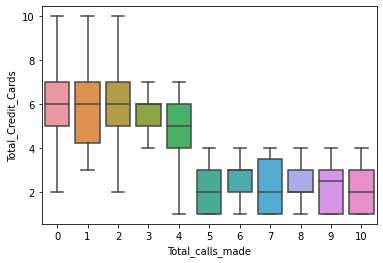

In [134]:
# relationship between total call made and total credit card
sns.boxplot( data = data, x = "Total_calls_made" , y ="Total_Credit_Cards" )
plt.show

- those with higher numbers of credit cards have the lowest number of calls made

<function matplotlib.pyplot.show(close=None, block=None)>

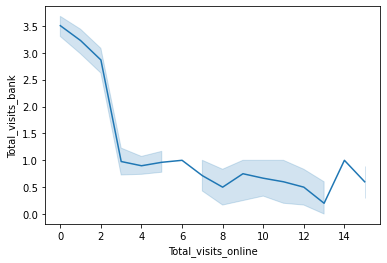

In [135]:
# relationship between total visits online and total bank visits
sns.lineplot( data = data, x = "Total_visits_online" , y ="Total_visits_bank" )
plt.show

- there is an inverse relationships between the bank and online visits. 

### Dropping unecessary  column


In [136]:
# remove customer key column
# renaming our final preprocessed data with X
X = data.drop(["Customer Key"], axis=1, )
X.head()

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,100000,2,1,1,0
1,2,50000,3,0,10,9
2,3,50000,7,1,3,4
3,4,30000,5,1,1,4
4,5,100000,6,0,12,3


## normalize our data

In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

## Implementing kmeans using inertia


In [138]:
# create an instance of the K-Means using inertia
SSE = []
"""
An empty list called SSE is created to store the sum of squared errors for each value of k (the number of clusters).
"""
for i in range(1, 11): # looping through 10 values of inertia
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_std)
    SSE.append(kmeans.inertia_)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows wi

In [139]:
SSE

[3960.0,
 2264.522863565032,
 1117.4060339225437,
 924.4266167856129,
 842.1004677186378,
 765.2983435024868,
 697.4591435996296,
 659.9679114407008,
 634.1115542448262,
 604.9124450642555]

In [140]:
# create a dataframe with no of clusters and SSE 
frame = pd.DataFrame({"Clusters": range(1, 11), "SSE": SSE})
frame

,Clusters,SSE
0,1,3960.000000
1,2,2264.522864
2,3,1117.406034
3,4,924.426617
4,5,842.100468
5,6,765.298344
6,7,697.459144
7,8,659.967911
8,9,634.111554
9,10,604.912445


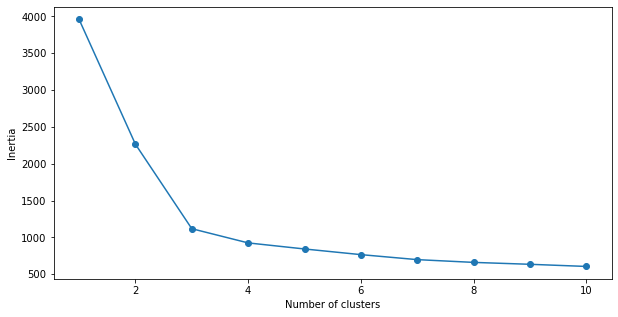

In [141]:
# Visualize the inertia
plt.figure(figsize = (10, 5))
plt.plot(frame["Clusters"], frame["SSE"], marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

- point 10 is where the error the minimum
- considering elbow curve, the error start to decrease at 3 or 4
- we can experiment with 3 or 4 number of clusters

In [142]:
# re-build the model with the optimal number of clusters

kmeans = KMeans(n_clusters=3, random_state = 0)

clusters = kmeans.fit_predict(X_std)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [143]:
clusters

array([1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

- 3 clusters are used; 0, 1 and 2

In [144]:
### insert the clusters into the original dataset
X["kmeans_cluster"] = clusters
X.head(8)

,Sl_No,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,kmeans_cluster
0,1,100000,2,1,1,0,1
1,2,50000,3,0,10,9,1
2,3,50000,7,1,3,4,1
3,4,30000,5,1,1,4,1
4,5,100000,6,0,12,3,2
5,6,20000,3,0,1,8,1
6,7,100000,5,0,11,2,2
7,8,15000,3,0,1,1,1


- row 0,1,2,3, 5 and7 were grouped to cluster 1
- row 4 and 6 were grouped to cluster 2

In [145]:
# remove kmeans_cluster back from the column
num_col = X.select_dtypes(include = "number").columns.tolist()

num_col.remove("kmeans_cluster")

<AxesSubplot:xlabel='kmeans_cluster', ylabel='Avg_Credit_Limit'>

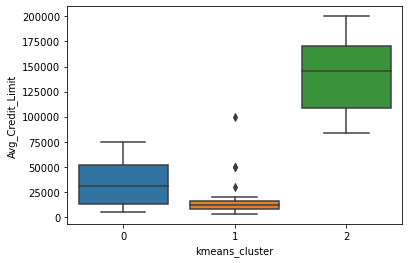

In [146]:
# Plotting the kmean cluster against one of the columns
sns.boxplot(x = X["kmeans_cluster"], y = X["Avg_Credit_Limit"])

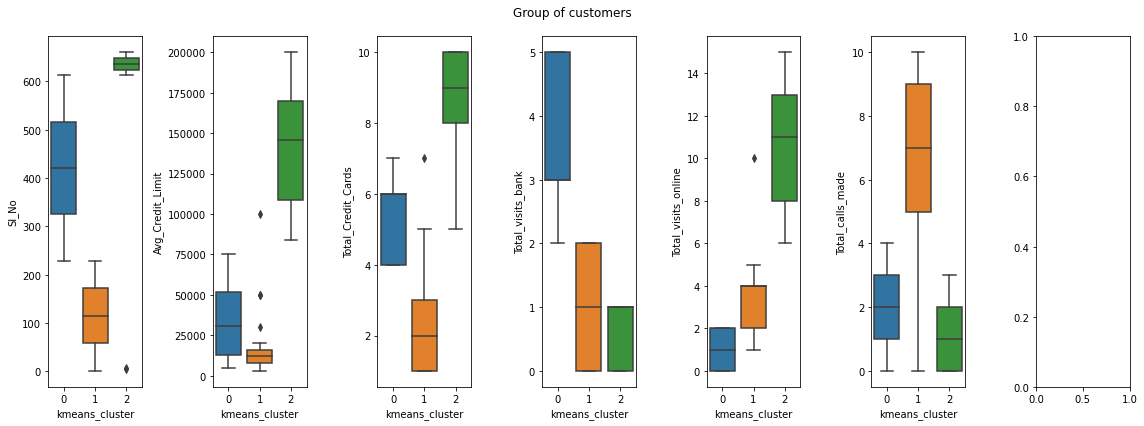

In [147]:
# Plotting the kmean cluster against all the columns
# examine the groups of customers
fig, ax = plt.subplots(1, 7, figsize = (16, 6))
fig.suptitle("Group of customers")

count = 0

for i in range(len(num_col)):
    sns.boxplot(ax = ax[i], x = X["kmeans_cluster"], y = X[num_col[count]])
    count += 1

fig.tight_layout()

- the first cluster (blue)are those with high SI number, low average credit limit, high total bank vists, low total online visits
- the second cluster (yellow) have low SI number, low average credit limit, low total credit cards, low total bank visits and high total calls made
- the thid cluster (green) are those with extremely high SI number, low average credit limit, high total credit cards, low total bank visits, high total online visits and low number of calls made

#### Implementing kmean using Silhouette score


In [148]:
# calculate silhouette score
from sklearn.metrics import silhouette_score
kmeans_sil = silhouette_score(X_std, clusters)
# it takes two arguments; the scaled data and the predicted clusters
kmeans_sil

0.5304536180389302

- the silhouette score is 53 percent which is somewhat acceptable

In [149]:
sil_scores = []

for i in range(2, 10): # silhouette score works with 2 groups upward
    kmeans = KMeans(n_clusters=i, random_state=10)
    clusters = kmeans.fit_predict(X_std)
    kmeans_sil = silhouette_score(X_std, clusters)
    sil_scores.append(kmeans_sil)


C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows wi

In [150]:
sil_scores

[0.4470141077035807,
 0.5304536180389302,
 0.37663553573943503,
 0.27628757287819206,
 0.25152718743189934,
 0.2598913964205118,
 0.23885523974353984,
 0.22740605222400748]

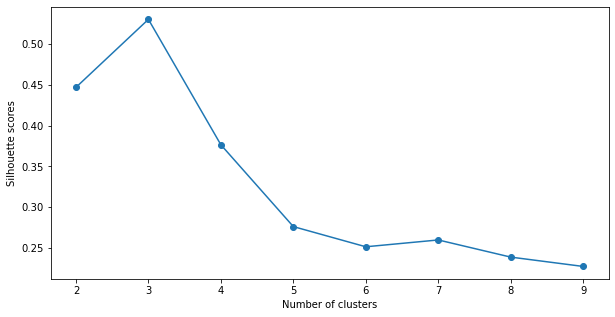

In [151]:
frame2 = pd.DataFrame({"Clusters": range(2, 10), "Sil": sil_scores})


plt.figure(figsize = (10, 5))
plt.plot(frame2["Clusters"], frame2["Sil"], marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette scores")
plt.show()

- number of clusters that gave the maximum number of score is 3 and this validates the result of inertia


#### Implementing DBSCAN

In [152]:
from sklearn.cluster import DBSCAN

In [153]:
# instantiate the model
dbscan = DBSCAN()
# the default eps is 0.5
# min_samples: the minimum number of points to consider;default is 5
db_labels = dbscan.fit_predict(X_std)

In [154]:
db_labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1,  3, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  7, -1, -1, -1,  1, -1,
       -1, -1,  6, -1, -1, -1, -1, -1,  7, -1, -1, -1,  0, -1, -1,  0,  1,
       -1,  2,  2,  1, -1,  3, -1,  3,  2,  3, -1, -1, -1,  3, -1,  3, -1,
       -1, -1, -1,  4, -1,  3, -1, -1,  2, -1,  2,  1, -1,  4,  3, -1,  4,
       -1, -1, -1,  4, -1,  1,  1, -1, -1,  6,  7, -1,  5,  8, -1,  5,  3,
        6, -1,  6, -1,  4,  8, -1,  7, -1, -1,  3,  3, -1, -1, -1, -1,  1,
       -1, -1,  4, -1, -1,  9,  7, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        5, -1, -1, -1, -1, -1, -1, -1, -1,  9, -1,  5, -1,  5,  1,  4,  3,
       -1,  8, -1, -1, -1, -1, -1,  5, -1, -1,  9, -1, -1, -1, -1, -1, -1,
        8,  9, -1, -1, -1,  9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  5, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

- we have a number of clusters
- we will loop through all eps and min_sample at the same time, calculate sillouette score and determine the optimal eps and min_sample

In [155]:
# Define the range of values for eps and min_samples
eps_range = [0.5, 1, 1.5, 2, ]
min_samples_range = [2, 3, 4, 5]

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        # Fit the model and generate cluster labels
        db_labels = dbscan.fit_predict(X_std)
        # Calculate the silhouette score for the current combination of eps and min_samples
        silhouette_avg = silhouette_score(X_std, db_labels)
        # Print the silhouette score for the current combination of eps and min_samples
        print(f"For eps={eps} and min_samples={min_samples}, the silhouette score is {silhouette_avg:.2f}")

For eps=0.5 and min_samples=2, the silhouette score is -0.06
For eps=0.5 and min_samples=3, the silhouette score is -0.18
For eps=0.5 and min_samples=4, the silhouette score is -0.27
For eps=0.5 and min_samples=5, the silhouette score is -0.36
For eps=1 and min_samples=2, the silhouette score is 0.44
For eps=1 and min_samples=3, the silhouette score is 0.47
For eps=1 and min_samples=4, the silhouette score is 0.47
For eps=1 and min_samples=5, the silhouette score is 0.48
For eps=1.5 and min_samples=2, the silhouette score is 0.34
For eps=1.5 and min_samples=3, the silhouette score is 0.41
For eps=1.5 and min_samples=4, the silhouette score is 0.41
For eps=1.5 and min_samples=5, the silhouette score is 0.41
For eps=2 and min_samples=2, the silhouette score is 0.20
For eps=2 and min_samples=3, the silhouette score is 0.32
For eps=2 and min_samples=4, the silhouette score is 0.32
For eps=2 and min_samples=5, the silhouette score is 0.32


- optimal eps of 1 and min_samples of 5 gives the highest the silhouette score of 0.48

In [156]:
## rebuilding the model with the optimal eps and min_samples
dbscan = DBSCAN(eps = 1, min_samples = 5 )
# the default eps is 0.5
# min_samples: the minimum number of points to consider;default is 5
db_labels = dbscan.fit_predict(X_std)

In [157]:
db_labels

array([-1, -1, -1, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

- most of the elements are 0, indicating that most of the data points are predicted to belong to the same cluster. However, there are also some elements with a value of -1, which typically means that the corresponding data point is considered an outlier and does not belong to any cluster.

##### evaluate the DBSCAN clustering performance


In [158]:
# evaluate the DBSCAN clustering performance
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X_std, db_labels)
print(f"The silhouette score of the DBSCAN clustering is: {silhouette_avg:.2f}")

The silhouette score of the DBSCAN clustering is: 0.48


- A score of 0.48 indicates that the clusters are somewhat well-separated, but there may be some overlap between them.

##### Visualize the clusters

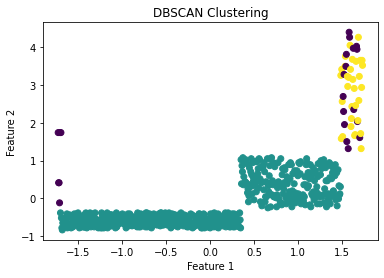

In [159]:
import matplotlib.pyplot as plt

plt.scatter(X_std[:, 0], X_std[:, 1], c=db_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

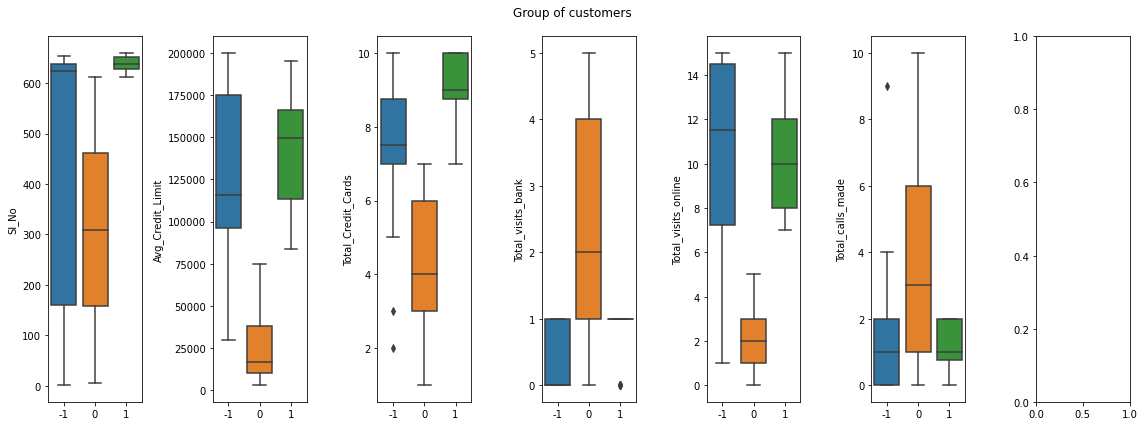

In [160]:
fig, ax = plt.subplots(1, 7, figsize=(16, 6))
fig.suptitle("Group of customers")

count = 0

for i in range(len(num_col)):
    sns.boxplot(ax=ax[i], x=db_labels, y=X[num_col[count]])
    count += 1

fig.tight_layout()

- customers in the firt cluster have high SI number, high average credit limit, high total credit cards, low bank visits, high online visits and low number of calls made. from the DB labels results they are considered as the outliers
- customers on the second group are the majority class and they have somewhat high SI number, low average credit limit, an average number of total credit cards, high bank visits , low online visits , somewhat low number of calls made
- customers on the third group have extremely high SI numbers, high average credit limit, high total credit cards, low bank vists,high online visits and low number of calls made

## Recommendation


Using the KMeans clustering visualization results, for the customers in the blue cluster (high SI number, low average credit limit, high total bank visits, low total online visits), the bank may want to focus on increasing the number of online visits and providing more online services to improve customer engagement. Since these customers have high SI numbers, they are likely to be loyal to the bank, and providing them with better online services could help retain their loyalty and improve.

For the customers in the yellow cluster (low SI number, low average credit limit, low total credit cards, low total bank visits, high total calls made), the credit card service provider may want to focus on increasing the number of credit cards held by the customers to improve their creditworthiness. This could be achieved through targeted marketing campaigns or by providing incentives to encourage customers to apply for additional credit cards. Additionally, the bank may want to provide more customer service options, such as online chat, to reduce the number of calls made by these customers.

For the customers in the green cluster (extremely high SI number, low average credit limit, high total credit cards, low total bank visits, high total online visits, and low number of calls made), the bank may want to focus on providing more online services and personalized  offerings. These customers have high SI numbers, indicating a strong relationship with the bank, and high total online visits, indicating a preference for online services. The bank could use this information to develop personalized product offerings and marketing campaigns that cater to the specific needs and preferences of these customers. Additionally, the bank may want to consider offering incentives to encourage these customers to increase their visits to the bank.